In [15]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [16]:
PREFIX = "/content/drive/My Drive/Project/"
!ls "$PREFIX"

AkaashNormal.ttf		      Inpainting.ipynb
cracklib-small			      input
DA_PatchingCombined.bak.ipynb	      input64
DA_PatchingCombined.ipynb	      input-large
DA_PatchingCombined-Neeraj.ipynb      Patching.ipynb
DA_PatchingCombined_water_mark.ipynb  Patching.py
DenoisingAutoencoder.bak.ipynb	      results
DenoisingAutoencoderMNIST.ipynb


In [0]:
import keras
from keras.datasets import mnist,  fashion_mnist
import numpy as np
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, InputLayer, Input
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random
import cv2

In [18]:
# data set of dim 28x28 greyscale images
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# original dimensions of train & test datasets
print("x_train.shape", x_train.shape)
print("x_test.shape", x_test.shape)
print("type(x_train)", type(x_train))
n, h, w = x_train.shape
c = 1

x_train.shape (60000, 28, 28)
x_test.shape (10000, 28, 28)
type(x_train) <class 'numpy.ndarray'>


In [19]:
# Reshape to include channel in dimension
# TODO: change channel to 3 when using RGB images
x_train = np.reshape(x_train, (len(x_train), h, w, c))  # by default uses `channels_last` image data format
x_test = np.reshape(x_test, (len(x_test), h, w, c))

# Dimensions after including channel info
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [0]:
def add_noise(data, noise_factor = 0.5):
    # add noise
    res = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape) 

    # clip to range
    res = np.clip(res, 0., 1.)
    return res


def random_line(fname):
    lines = open(fname).read().splitlines()
    return random.choice(lines)

def helper_watermark(image_name):
    image_name = image_name.reshape(image_name.shape[0], image_name.shape[1])
    im = Image.fromarray(image_name, "L")
    initial_coordinate = 0
    font_type = ImageFont.truetype((PREFIX+'AkaashNormal.ttf'), 10)
    
    for j in range(3):
        sentence = ""
        for i in range(2):
            sentence = sentence + " " + random_line(PREFIX + 'cracklib-small')
        draw = ImageDraw.Draw(im)
        draw.text((5, initial_coordinate), sentence, font=font_type, fill=(0))
        initial_coordinate = initial_coordinate + 5
#     im.show()
    return np.asarray(im)

def add_water_mark(data):
    noisy = np.array([helper_watermark(i) for i in data])
    noisy = noisy.reshape(noisy.shape[0], noisy.shape[1], noisy.shape[2] , c)
    return noisy

x_train_noisy = add_water_mark(x_train)
x_test_noisy = add_water_mark(x_test)

# x_train_noisy = add_noise(x_train)
# x_test_noisy = add_noise(x_test)

In [0]:
# normalize to range [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_noisy = x_train_noisy.astype('float32') / 255.
x_test_noisy = x_test_noisy.astype('float32') / 255.

In [0]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

In [0]:
# KL Divergence regularizer for hidden unit activations
import keras # if using keras
import tensorflow as tf
# from tensorflow import keras # if using tf.keras
kullback_leibler_divergence = keras.losses.kullback_leibler_divergence
K = keras.backend

def kl_divergence_regularizer(activations):
    rho_hat = K.mean(activations, axis=0)
    nprho = np.full((rho_hat.get_shape().as_list()[0],) ,0.05)
    rho = tf.convert_to_tensor(nprho, dtype=tf.float32)
    return 0.01 * (kullback_leibler_divergence(rho, rho_hat)
                 + kullback_leibler_divergence(1 - rho, 1 - rho_hat))

In [24]:
x_train.shape, x_train_noisy.shape, x_test.shape, x_test_noisy.shape

((60000, 28, 28, 1),
 (60000, 28, 28, 1),
 (10000, 28, 28, 1),
 (10000, 28, 28, 1))

In [25]:
# reshape(flatten) so that we can pass to neural network
x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_train_noisy = x_train_noisy.reshape(len(x_train_noisy), np.prod(x_train_noisy.shape[1:]))

x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))
x_test_noisy = x_test_noisy.reshape(len(x_test_noisy), np.prod(x_test_noisy.shape[1:]))

# shape after flattening
x_train.shape, x_train_noisy.shape, x_test.shape, x_test_noisy.shape

((60000, 784), (60000, 784), (10000, 784), (10000, 784))

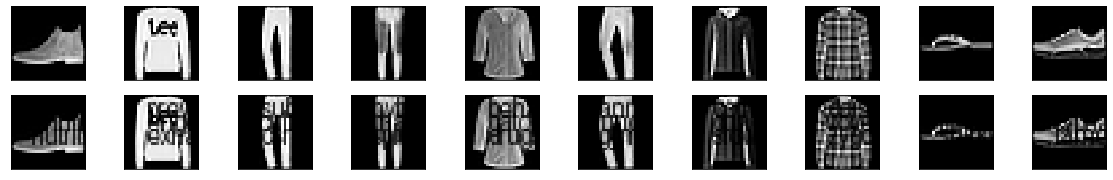

In [26]:
# print first 10 test images
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+10)
    plt.imshow(x_test_noisy[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

plt.show()

In [27]:
lambdaa = 0.000001
input_layer = Input(shape=(784,))
hidden_layer = Dense(units=3*784, activation='sigmoid', 
                    activity_regularizer=kl_divergence_regularizer,
                    kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(input_layer)
output_layer = Dense(units=784, activation='sigmoid',
                    kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(hidden_layer)
da1 = Model(input_layer, output_layer)
da1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2352)              1846320   
_________________________________________________________________
dense_4 (Dense)              (None, 784)               1844752   
Total params: 3,691,072
Trainable params: 3,691,072
Non-trainable params: 0
_________________________________________________________________


In [28]:
from keras import optimizers
adam = optimizers.Adam(lr=0.1)
da1.compile(optimizer=adam, loss='mse')
da1.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=120,
                shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





60000/60000 [==============================] - 10s 164us/step - loss: 0.7983
Epoch 2/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.2580
Epoch 3/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.2679
Epoch 4/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.2774
Epoch 5/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.3179
Epoch 6/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.3510
Epoch 7/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.5414
Epoch 8/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.3548
Epoch 9/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.4242
Epoch 10/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.3913
Epoch 11/50
60000/60000 [==========

In [0]:
predicted = da1.predict(x_test_noisy)

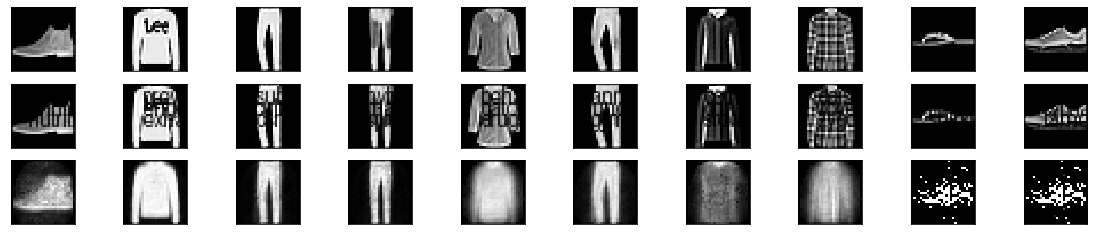

In [30]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy images
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(x_test_noisy[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

In [31]:
import pandas as pd

hiddenLayerWeights = pd.DataFrame(da1.layers[1].get_weights()[0]).values
hiddenLayerBias = pd.DataFrame(da1.layers[1].get_weights()[1]).values
hiddenLayerWeights.shape, type(hiddenLayerWeights), hiddenLayerBias.shape, type(hiddenLayerBias)

Wx = np.dot(x_train_noisy, hiddenLayerWeights)
b =  hiddenLayerBias.T
hX = sigmoid(Wx+b)

Wy = np.dot(x_train, hiddenLayerWeights)
hY = sigmoid(Wy + b)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [32]:
hX.shape, hY.shape

((60000, 2352), (60000, 2352))

In [33]:
input_layer2 = Input(shape=(3*784,))
hidden_layer2 = Dense(units=3*3*784, activation='sigmoid',
                    activity_regularizer=kl_divergence_regularizer,
                    kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(input_layer2)
output_layer2 = Dense(units=3*784, activation='sigmoid',
                    kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(hidden_layer2)
da2 = Model(input_layer2, output_layer2)
da2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2352)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 7056)              16602768  
_________________________________________________________________
dense_6 (Dense)              (None, 2352)              16598064  
Total params: 33,200,832
Trainable params: 33,200,832
Non-trainable params: 0
_________________________________________________________________


In [34]:
da2.compile(optimizer='adam', loss='mse')
da2.fit(hX, hY,
                epochs=50,
                batch_size=120,
                shuffle=True)

Epoch 1/50
60000/60000 [==============================] - 33s 544us/step - loss: 10.5435
Epoch 2/50
60000/60000 [==============================] - 32s 535us/step - loss: 1.6222
Epoch 3/50
60000/60000 [==============================] - 32s 531us/step - loss: 0.4887
Epoch 4/50
60000/60000 [==============================] - 32s 531us/step - loss: 0.2556
Epoch 5/50
60000/60000 [==============================] - 32s 531us/step - loss: 0.2023
Epoch 6/50
60000/60000 [==============================] - 32s 530us/step - loss: 0.1905
Epoch 7/50
60000/60000 [==============================] - 32s 531us/step - loss: 0.1803
Epoch 8/50
60000/60000 [==============================] - 32s 532us/step - loss: 0.1679
Epoch 9/50
60000/60000 [==============================] - 32s 531us/step - loss: 0.1563
Epoch 10/50
60000/60000 [==============================] - 32s 530us/step - loss: 0.1440
Epoch 11/50
60000/60000 [==============================] - 32s 531us/step - loss: 0.1288
Epoch 12/50
60000/60000 [====

In [0]:
# Extract weights
W1, B1 = da1.layers[1].get_weights()
W1_dash, B1_dash = da1.layers[2].get_weights()

W2, B2 = da2.layers[1].get_weights()
W2_dash, B2_dash = da2.layers[2].get_weights()


In [36]:
W1.shape, W2.shape, W2_dash.shape, W1_dash.shape
# B1.shape, B2.shape, B2_dash.shape, B1_dash.shape
# len(B1), len(B2), len(B2_dash), len(B1_dash)

((784, 2352), (2352, 7056), (7056, 2352), (2352, 784))

In [37]:
input_layer = Input(shape=(W1.shape[0],))
h1 = Dense(units=W1.shape[1], activation='sigmoid', 
                    kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(input_layer)
h2 = Dense(units=W2.shape[1], activation='sigmoid', 
                    kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(h1)
h3 = Dense(units=W2_dash.shape[1], activation='sigmoid', 
                    kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(h2)
output_layer = Dense(units=W1_dash.shape[1], activation='sigmoid',
                    kernel_regularizer=keras.regularizers.l2(lambdaa)
                    )(h3)

dnn = Model(input_layer, output_layer)

# Initialize with pretrained weights
B1 = np.random.uniform(0,1,B1.shape)
B2 = np.random.uniform(0,1,B2.shape)
B1_dash = np.random.uniform(0,1,B1_dash.shape)
B2_dash = np.random.uniform(0,1,B2_dash.shape)

dnn.layers[1].set_weights([W1, B1])
dnn.layers[2].set_weights([W2, B2])
dnn.layers[3].set_weights([W2_dash, B2_dash])
dnn.layers[4].set_weights([W1_dash, B1_dash])

dnn.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2352)              1846320   
_________________________________________________________________
dense_8 (Dense)              (None, 7056)              16602768  
_________________________________________________________________
dense_9 (Dense)              (None, 2352)              16598064  
_________________________________________________________________
dense_10 (Dense)             (None, 784)               1844752   
Total params: 36,891,904
Trainable params: 36,891,904
Non-trainable params: 0
_________________________________________________________________


In [0]:
# x_sample = x_train[0].reshape(28, 28)
# plt.imshow(x_sample, interpolation='nearest')
# plt.show()

In [39]:
dnn.compile('adam', loss='mse')
dnn.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=120,
                shuffle=True)

Epoch 1/50
60000/60000 [==============================] - 37s 621us/step - loss: 0.1675
Epoch 2/50
60000/60000 [==============================] - 36s 607us/step - loss: 0.0641
Epoch 3/50
60000/60000 [==============================] - 36s 608us/step - loss: 0.0409
Epoch 4/50
60000/60000 [==============================] - 36s 607us/step - loss: 0.0322
Epoch 5/50
60000/60000 [==============================] - 36s 607us/step - loss: 0.0273
Epoch 6/50
60000/60000 [==============================] - 36s 607us/step - loss: 0.0246
Epoch 7/50
60000/60000 [==============================] - 36s 607us/step - loss: 0.0231
Epoch 8/50
60000/60000 [==============================] - 36s 606us/step - loss: 0.0221
Epoch 9/50
60000/60000 [==============================] - 36s 607us/step - loss: 0.0214
Epoch 10/50
60000/60000 [==============================] - 36s 606us/step - loss: 0.0209
Epoch 11/50
60000/60000 [==============================] - 36s 607us/step - loss: 0.0205
Epoch 12/50
60000/60000 [=====

In [0]:
predicted2 = dnn.predict(x_test_noisy)

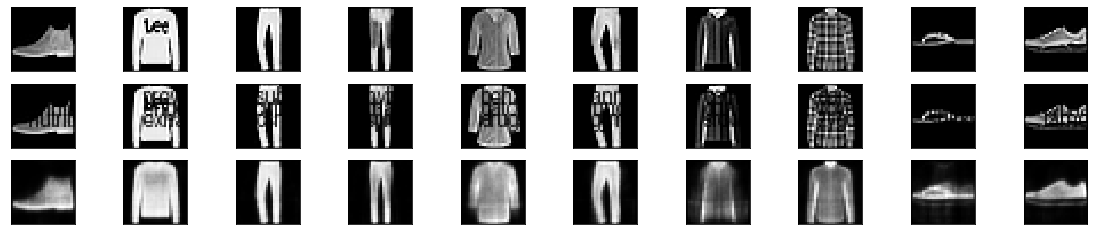

In [41]:
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy images
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(x_test_noisy[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(3, 20, 2 * 20 + i + 1)
    plt.imshow(predicted2[i].reshape(h, w))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()